# Audio Language Model (AWD-LSTM)

## System setup

There are a few system libraries and Python packages required to work with audio. If needed, uncomment and run this cell.

Note that the cell returns an error code whether there's an error or not. This seems to be due to Jupyter's shell command handling. You'll need to read the outputs in the cell to determine whether anything actually went wrong - sorry!

In [2]:
# Run this cell first!
# %%bash
# ./install.sh
# ./buildFastAiAudio.sh

<span style="color:red">**Don't forget to restart your notebook kernel after you've installed these modules!**</span> 

### fastai default setup

In [3]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

Import FastAI Audio modules here:

In [5]:
from audio import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/Python dependencies. You might need to re-run the "System setup" cell again.

In [6]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

## Preparing the data

We're going to do **speaker identification** with [the Free ST American English Corpus](http://www.openslr.org/45/ ) data. It's a small-enough, freely-available dataset. 

Note that we started using the [TIMIT dataset](https://catalog.ldc.upenn.edu/LDC93S1), but the copyright isn't clear, and the data is hard to download. The best option was [this GitHub readme](https://github.com/philipperemy/timit) which pointed to [this AcademicTorrents link](http://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3) but A) nuts to downloading torrents and B) not sure about licensing given LDC charges a fee.

### Download

Use this file to prep the data. It's a bit more complex than the usual FastAI data setup flow because `untar_data` doesn't accept a filename with a .tgz extension (it adds it itself) and the .tgz file we're using doesn't extract itself into its own directory (sigh). 

In [7]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))

In [8]:
untar_data(data_url, dest = data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

Did we get anything?

In [9]:
data_folder.ls()[:5]

[PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00359.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00100.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00381.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00275.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00107.wav')]

Hurray!

Sanity check - play a file just using torchaudio.

In [10]:
sig,sr = torchaudio.load(data_folder.ls()[0])
Audio(data=sig, rate=sr)

### Load into a DataBunch

Here we'll load our audio data in an idiomatic to fastai way. 

First we make an AudioList of our downloaded data.

In [40]:
import glob

In [41]:
slice_length = 2000 # 1/8 of a second

In [42]:
def split_arr(arr, seg_len):
    final = []
    for i in range(0, arr.shape[1], seg_len):
        final.append(arr[0, i:i+seg_len])
    return final

In [43]:
def get_audio_slices(file_p, slice_len):
    sig,sr = torchaudio.load(file_p)
    spl = split_arr(sig, slice_len)
    return pd.DataFrame(zip(spl, [sr] * len(spl)), columns=['sig', 'sr'])

In [44]:
slices = get_audio_slices('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav', slice_length)
slices.head()

,sig,sr
0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",16000
1,"[tensor(-0.0001), tensor(-9.1553e-05), tensor(...",16000
2,"[tensor(-3.0518e-05), tensor(-0.0002), tensor(...",16000
3,"[tensor(-0.0002), tensor(-0.0001), tensor(-0.0...",16000
4,"[tensor(-0.0001), tensor(-3.0518e-05), tensor(...",16000


In [45]:
# for aud_file in glob.glob(str(data_folder) + '/**/*.wav', recursive=True)[:2]:
#     get_audio_slices(aud_file, slice_length)

In [46]:
tfms = get_audio_transforms(spectro=False,
                            mx_to_pad=2000,
                            white_noise=False,
                            modulate_volume=False,
                            random_cutout=False,
                            pad_with_silence=False,
                            pitch_warp=False,
                            down_and_up=False)

In [11]:
al = AudioList.from_df(slices, path='.', cols=['sig', 'sr'])

NameError: name 'slices' is not defined

In [48]:
al[0]

AudioItem REPRESENTATION

In [49]:
data = (al
        .split_by_rand_pct(0.2)
        .label_const(0) # FIXME, hack
        .transform(tfms)
        .databunch(bs=16))

In [50]:
xls = []
for i in range(10):
    x, y = next(iter(data.train_dl))
    xls.append(x)

In [51]:
stacked = torch.stack(xls)

In [52]:
stacked.shape

torch.Size([10, 16, 2000])

## TODO:
Pick up here after making a AudioSequenceItem

In [62]:
class FakeLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.Sequential(
            nn.LSTM(input_size=2000, hidden_size=4000, num_layers=1),
            nn.LSTM(input_size=4000, hidden_size=4000, num_layers=1),
#             nn.LSTM(input_size=4000, hidden_size=4000, num_layers=1),
#             nn.Linear(in_features=4000, out_features=2000),
        )
        
    def forward(self, *xb):
        return self.rnn(*xb)    

In [63]:
my_fake = FakeLSTM()

In [64]:
my_fake.cuda()

FakeLSTM(
  (rnn): Sequential(
    (0): LSTM(2000, 4000)
  )
)

In [65]:
my_fake(stacked)

(tensor([[[-1.2228e-03, -2.1382e-03,  4.9532e-03,  ..., -2.6598e-03,
           -2.5252e-03,  4.7292e-03],
          [-1.6201e-03, -2.3810e-03,  4.5006e-03,  ..., -1.5567e-03,
           -1.7962e-03,  4.7057e-03],
          [-1.5888e-03, -2.4075e-03,  4.5079e-03,  ..., -1.5562e-03,
           -1.7750e-03,  4.6745e-03],
          ...,
          [ 1.4492e-02,  1.0908e-02,  1.0082e-02,  ...,  9.7393e-03,
            8.7001e-03,  6.1342e-03],
          [-2.4946e-03, -2.6853e-03,  4.9906e-03,  ..., -3.6981e-04,
           -2.1592e-03,  4.9623e-03],
          [-1.6167e-03, -2.3253e-03,  4.4740e-03,  ..., -1.6194e-03,
           -1.7975e-03,  4.7365e-03]],
 
         [[-1.4537e-03, -3.8891e-03,  7.4965e-03,  ..., -3.1908e-03,
           -3.4373e-03,  7.0657e-03],
          [ 1.4475e-02,  9.1370e-03,  1.3060e-02,  ...,  8.4846e-03,
            7.2264e-03,  8.5432e-03],
          [-1.6277e-03, -4.1281e-03,  7.4046e-03,  ..., -2.8179e-03,
           -3.2258e-03,  7.0252e-03],
          ...,
    

In [87]:
fake_lstm = nn.LSTM(200, 100, 1);
for p in fake_lstm.parameters():
    print(p.shape)

torch.Size([400, 200])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])


In [100]:
updated.shape

torch.Size([1, 1, 2000])

In [ ]:
for xb,yb in progress_bar(learn.data.train_dl, parent=pbar):
        xb, yb = cb_handler.on_batch_begin(xb, yb)
        loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler)
        if cb_handler.on_batch_end(loss): break


In [113]:
# rnn = nn.LSTM(input_size=2000, hidden_size=4000, num_layers=1)
output, hidden = rnn(updated)
output.shape

AttributeError: 'tuple' object has no attribute 'dim'

In [ ]:
output[0][0][-10:]

In [90]:
updated[0][0][-10:]

tensor([-9.1553e-05, -9.1553e-05, -6.1035e-05, -2.1362e-04,  6.1035e-05,
         6.1035e-05, -3.0518e-05, -6.1035e-05, -9.1553e-05,  6.1035e-05])

### AWD_LSTM Schema

```
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(8758, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(8758, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=8758, bias=True)
    (output_dp): RNNDropout()
  )
)
```

In [115]:
??AWD_LSTM

Init signature:
AWD_LSTM(
    vocab_sz: int,
    emb_sz: int,
    n_hid: int,
    n_layers: int,
    pad_token: int = 1,
    hidden_p: float = 0.2,
    input_p: float = 0.6,
    embed_p: float = 0.1,
    weight_p: float = 0.5,
    qrnn: bool = False,
    bidir: bool = False,
)
Source:        
class AWD_LSTM(nn.Module):
    "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."

    initrange=0.1

    def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int=1, hidden_p:float=0.2,
                 input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, qrnn:bool=False, bidir:bool=False):
        super().__init__()
        self.bs,self.qrnn,self.emb_sz,self.n_hid,self.n_layers = 1,qrnn,emb_sz,n_hid,n_layers
        self.n_dir = 2 if bidir else 1
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        if self.qrnn:
            #Using QRNN requires an installati

## Modeling

In [36]:
newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
newlayer.cuda() # Our layer should use cuda, since the rest of the model will.

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [37]:
## Standard learner
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

## Replace the first layer in the resnet18 model with our first layer
learn.model[0][0] = newlayer

In [38]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.773593,0.846765,0.735677,00:14
1,1.004221,0.462579,0.845052,00:14
2,0.654266,0.372739,0.867188,00:14
3,0.449424,0.317473,0.890625,00:14
4,0.335591,0.300995,0.894531,00:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


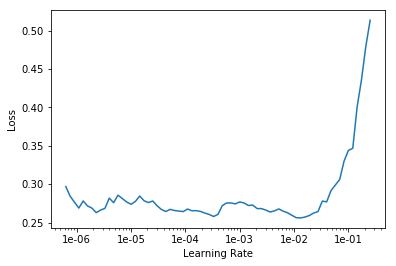

In [39]:
lr_find(learn)
learn.recorder.plot()

**Don't forget** to update the learning rate parameter below according to what you see in the chart above!

In [ ]:
tfms

([functools.partial(<function tfm_add_white_noise at 0x7f2780901f28>, noise_scl=0.005),
  functools.partial(<function tfm_pad_to_max at 0x7f2780906378>, mx=80000),
  <function exp.nb_DataAugmentation.tfm_spectro(ad: exp.nb_AudioCommon.AudioData, n_mels=128)>],
 [functools.partial(<function tfm_pad_to_max at 0x7f2780906378>, mx=80000),
  <function exp.nb_DataAugmentation.tfm_spectro(ad: exp.nb_AudioCommon.AudioData, n_mels=128)>])

In [ ]:
learn.fit_one_cycle(10, 1e-03)
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.251058,0.284367,0.897135,00:14
1,0.228227,0.245356,0.908854,00:14


### Interpret the results

All done! The results look OK at ~86% accuracy, but we can probably do better. We can do some basic examination of our results to try to get a feeling for where it might be going wrong.
Based on what we see here, we can go back and tweak the model accordingly later.

In [44]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

m0002/m0001 / 6.35 / 0.00


AttributeError: 'Tensor' object has no attribute 'sig'

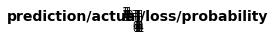

In [45]:
interp.plot_top_losses(5, figsize=(0.1,0.1))

In [ ]:
interp.plot_confusion_matrix()

## Improving Our Model with Data Augmentation

In [46]:
audios = AudioList.from_folder(data_folder); audios

AudioList (3842 items)
REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS

(array([135., 676., 998., 844., 603., 313., 132.,  69.,  52.,  20.]),
 array([ 26240.,  39616.,  52992.,  66368.,  79744.,  93120., 106496., 119872., 133248., 146624., 160000.]),
 <a list of 10 Patch objects>)

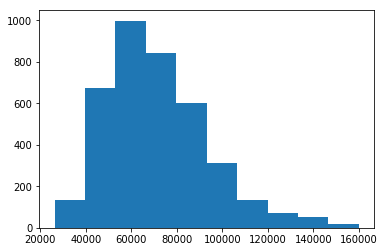

In [47]:
audio_lengths = tensor([a.data.sig.shape[0] for a in audios])
plt.hist(audio_lengths)

In [82]:
tfms = get_audio_transforms(spectro=True,
                            white_noise=True,
                            modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False, mx_to_pad=80000)

In [83]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'

data = (audios
        .split_by_rand_pct(0.2)
        .label_from_re(label_pattern)
        .transform(tfms)
        .databunch())

In [84]:
data.get(1)

AudioItem REPRESENTATION

In [75]:
f"Found {data.c} classes, \
{len(data.train_ds)} training samples,\
{len(data.valid_ds)} validation samples"

'Found 10 classes, 3074 training samples,768 validation samples'

In [76]:
batch = data.one_batch()

In [77]:
batch[0].shape

torch.Size([64, 80000])

In [85]:
data.hear_ex()

m0002


m0002


f0003


In [86]:
newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
newlayer.cuda() # Our layer should use cuda, since the rest of the model will.

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [87]:
## Standard learner
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

## Replace the first layer in the resnet18 model with our first layer
learn.model[0][0] = newlayer

In [88]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.213771,1.212566,0.625000,00:09
1,1.641814,0.798738,0.735677,00:09
2,1.248678,0.586198,0.798177,00:09
3,0.979437,0.494022,0.833333,00:09
4,0.822009,0.483017,0.839844,00:09


In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, 8e-5)
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.759403,0.565678,0.804688,00:09
1,0.759987,0.549776,0.808594,00:09


## Fin.